# EDA for Covid-19 data in Mexico

This notebook outlines the Exploratory Data Analysis (EDA) of COVID-19 data from Mexico, focusing on understanding the key patterns and trends necessary for developing a compartmental epidemiological model of the disease. Specifically, we want to answer the following questions:
* What type of data should we work with? Should we use daily counts vs weekly aggregates vs rolling averages?
* Can we use a single model at the national level, or are independent models needed across specific geographic regions?
* Are there any significant differences in disease behavior driven by age and or gender?

**Index**
* [Understanding delays in reports](#understanding-delays-in-reports)
* [Data Visualization](#data-visualization)
* [Analysis of Onset to Event Timeframes](#analysis-of-onset-to-event-timeframes)
* [Spatial Analysis](#spatial-analysis)
* [Time Series Analysis](#time-series-analysis)
* [Demographics](#demographics)

In [1]:
# Import all necesary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
import geopandas as gpd
import plotly.express as px
import seaborn as sns
from datetime import datetime
from itertools import product
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Understanding Delays in Reports


In this section we shall rely on the `final_data_2020_08_01_df`, `final_data_2020_08_08_df`, `final_data_2020_08_15_df`, `onset_to_hospital_df` and `onset_to_death_df`  dataframes previously derived through the ETL process.

In [10]:
# Load the DataFrames from the ETL pickle files
state_data_2020_08_01 = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/final_data_2020_08_01_df.feather')
state_data_2020_08_08 = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/final_data_2020_08_08_df.feather')
state_data_2020_08_15 = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/final_data_2020_08_15_df.feather')

print(state_data_2020_08_01.tail())
print(state_data_2020_08_08.tail())
print(state_data_2020_08_15.tail())

           date  state  confirmed_cases  confirmed_deaths
6459 2020-08-01     28              0.0               0.0
6460 2020-08-01     29              0.0               0.0
6461 2020-08-01     30              0.0               0.0
6462 2020-08-01     31              0.0               0.0
6463 2020-08-01     32              0.0               0.0
           date  state  confirmed_cases  confirmed_deaths
6683 2020-08-08     28              0.0               0.0
6684 2020-08-08     29              0.0               0.0
6685 2020-08-08     30              0.0               0.0
6686 2020-08-08     31              0.0               0.0
6687 2020-08-08     32              0.0               0.0
           date  state  confirmed_cases  confirmed_deaths
6907 2020-08-15     28              0.0               0.0
6908 2020-08-15     29              0.0               0.0
6909 2020-08-15     30              0.0               0.0
6910 2020-08-15     31              0.0               0.0
6911 2020-08-1

In [11]:
# Aggregate data to national level
national_data_2020_08_01 = state_data_2020_08_01.groupby('date').agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()

national_data_2020_08_08 = state_data_2020_08_08.groupby('date').agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()

national_data_2020_08_15 = state_data_2020_08_15.groupby('date').agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()

In [12]:
national_data_2020_08_01[-14:]

,date,confirmed_cases,confirmed_deaths
188,2020-07-19,4996.0,545.0
189,2020-07-20,6774.0,532.0
190,2020-07-21,3944.0,548.0
191,2020-07-22,3514.0,479.0
192,2020-07-23,3184.0,464.0
193,2020-07-24,3035.0,430.0
194,2020-07-25,2961.0,427.0
195,2020-07-26,1694.0,440.0
196,2020-07-27,1597.0,332.0
197,2020-07-28,797.0,356.0


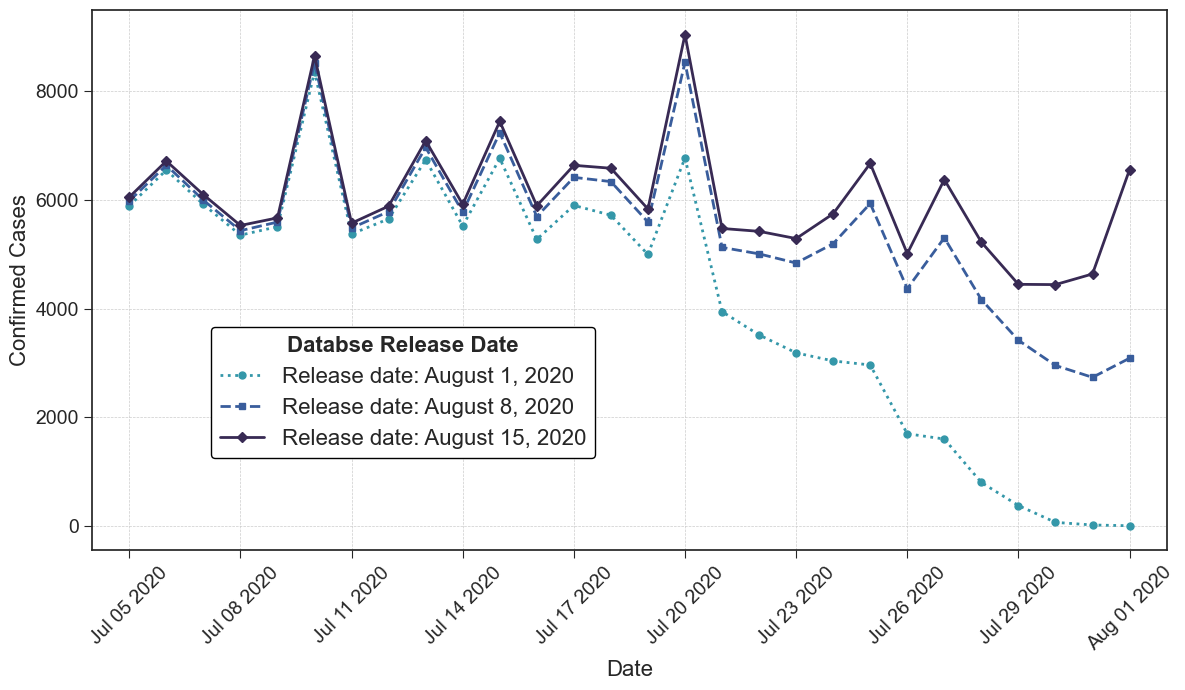

In [41]:
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('mako',4) 

# Define the date range
start_date = pd.Timestamp('2020-07-05')
end_date = pd.Timestamp('2020-08-01')

# Filter each dataset within the desired date range
plot_data_2020_08_01 = national_data_2020_08_01[(national_data_2020_08_01['date'] >= start_date) & (national_data_2020_08_01['date'] <= end_date)]
plot_data_2020_08_08 = national_data_2020_08_08[(national_data_2020_08_08['date'] >= start_date) & (national_data_2020_08_08['date'] <= end_date)]
plot_data_2020_08_15 = national_data_2020_08_15[(national_data_2020_08_15['date'] >= start_date) & (national_data_2020_08_15['date'] <= end_date)]

# Plotting the filtered data
plt.figure(figsize=(12, 7))
plt.plot(plot_data_2020_08_01['date'], plot_data_2020_08_01['confirmed_cases'], 
         color=colors[2], marker='o', linestyle='dotted', linewidth=2, markersize=5, label='Release date: August 1, 2020')
plt.plot(plot_data_2020_08_08['date'], plot_data_2020_08_08['confirmed_cases'], 
         color=colors[1], marker='s', linestyle= 'dashed', linewidth=2, markersize=5, label='Release date: August 8, 2020')
plt.plot(plot_data_2020_08_15['date'], plot_data_2020_08_15['confirmed_cases'], 
         color=colors[0], marker='D', linewidth=2, markersize=5, label='Release date: August 15, 2020')

# Formatting the x-axis to show dates clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))  
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xlim(start_date-pd.Timedelta(days=1), end_date + pd.Timedelta(days=1))


plt.xlabel('Date', fontsize=16)
plt.ylabel('Confirmed Cases', fontsize=16)
#plt.title('Updates to COVID-19 daily reported persist beyond the first week with majority of changes happening up to the second week', fontsize=16)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.legend(
    loc='lower left',  
    bbox_to_anchor=(0.1, 0.15), 
    fontsize=16, 
    title='Databse Release Date', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white' 
)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

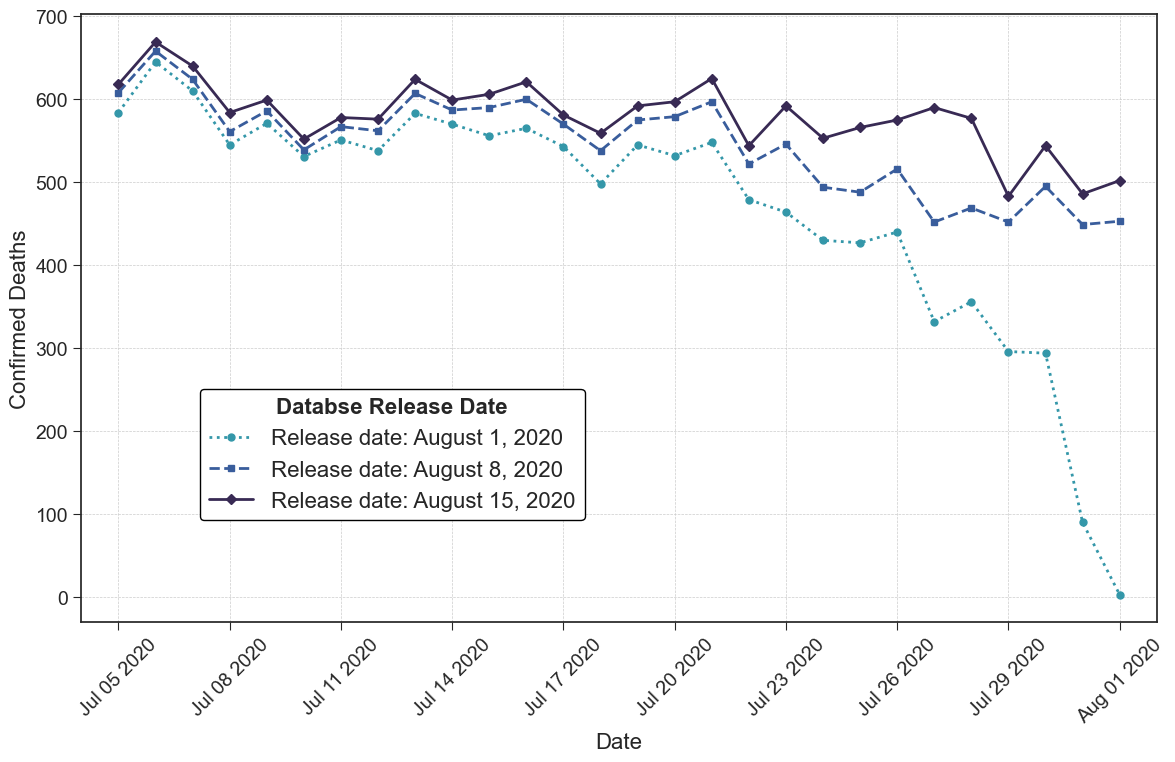

In [43]:
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('mako',4) 

# Define the date range
start_date = pd.Timestamp('2020-07-05')
end_date = pd.Timestamp('2020-08-01')

# Filter each dataset within the desired date range
plot_data_2020_08_01 = national_data_2020_08_01[(national_data_2020_08_01['date'] >= start_date) & (national_data_2020_08_01['date'] <= end_date)]
plot_data_2020_08_08 = national_data_2020_08_08[(national_data_2020_08_08['date'] >= start_date) & (national_data_2020_08_08['date'] <= end_date)]
plot_data_2020_08_15 = national_data_2020_08_15[(national_data_2020_08_15['date'] >= start_date) & (national_data_2020_08_15['date'] <= end_date)]

# Plotting the filtered data
plt.figure(figsize=(12, 7))
plt.plot(plot_data_2020_08_01['date'], plot_data_2020_08_01['confirmed_deaths'], 
         color=colors[2], marker='o', linestyle='dotted', linewidth=2, markersize=5, label='Release date: August 1, 2020')
plt.plot(plot_data_2020_08_08['date'], plot_data_2020_08_08['confirmed_deaths'], 
         color=colors[1], marker='s', linestyle= 'dashed', linewidth=2, markersize=5, label='Release date: August 8, 2020')
plt.plot(plot_data_2020_08_15['date'], plot_data_2020_08_15['confirmed_deaths'], 
         color=colors[0], marker='D', linewidth=2, markersize=5, label='Release date: August 15, 2020')

# Formatting the x-axis to show dates clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))  
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xlim(start_date-pd.Timedelta(days=1), end_date + pd.Timedelta(days=1))

plt.xlabel('Date', fontsize=16)
plt.ylabel('Confirmed Deaths', fontsize=16)
#plt.title('Majority of changes to COVID-19 death reports occur within the first week of reporting', fontsize=16)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.legend(
    loc='lower left',  
    bbox_to_anchor=(0.1, 0.15), 
    fontsize=16, 
    title='Databse Release Date', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white'               
)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [44]:
onset_to_hospital_df = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/onset_to_hospital_df.feather')
onset_to_hospital_df

,onset_date,hospital_date,state,gender,age,OnsetToHospital
0,2020-11-30,2020-12-06,24,1,55,6
1,2020-07-20,2020-07-28,8,2,35,8
2,2020-06-10,2020-06-12,31,1,56,2
3,2020-05-30,2020-06-02,1,1,58,3
4,2020-06-30,2020-07-01,31,2,37,1
...,...,...,...,...,...,...
7712610,2023-08-27,2023-08-27,15,1,49,0
7712611,2023-08-28,2023-08-28,15,1,27,0
7712612,2023-08-28,2023-08-28,15,2,26,0
7712613,2023-08-29,2023-08-29,9,2,68,0


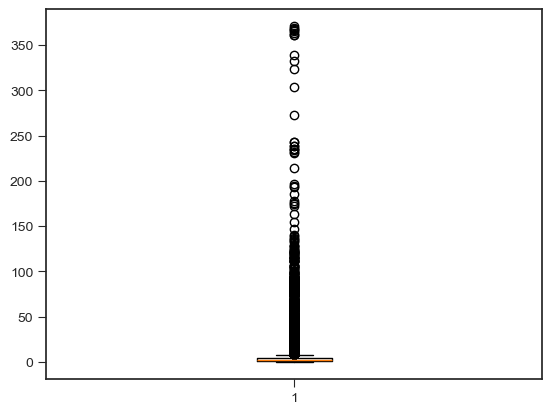

13.0


In [45]:
plt.boxplot(onset_to_hospital_df['OnsetToHospital'])
plt.show()
print(onset_to_hospital_df['OnsetToHospital'].quantile(0.99))

In [20]:
# Filter out data beyond the 99th quantile
OTH_99Q = onset_to_hospital_df[onset_to_hospital_df['OnsetToHospital'] <= onset_to_hospital_df['OnsetToHospital'].quantile(0.99)].reset_index(drop=True)
OTH_99Q

,onset_date,hospital_date,state,gender,age,OnsetToHospital
0,2020-11-30,2020-12-06,24,1,55,6
1,2020-07-20,2020-07-28,8,2,35,8
2,2020-06-10,2020-06-12,31,1,56,2
3,2020-05-30,2020-06-02,1,1,58,3
4,2020-06-30,2020-07-01,31,2,37,1
...,...,...,...,...,...,...
7648398,2023-08-27,2023-08-27,15,1,49,0
7648399,2023-08-28,2023-08-28,15,1,27,0
7648400,2023-08-28,2023-08-28,15,2,26,0
7648401,2023-08-29,2023-08-29,9,2,68,0


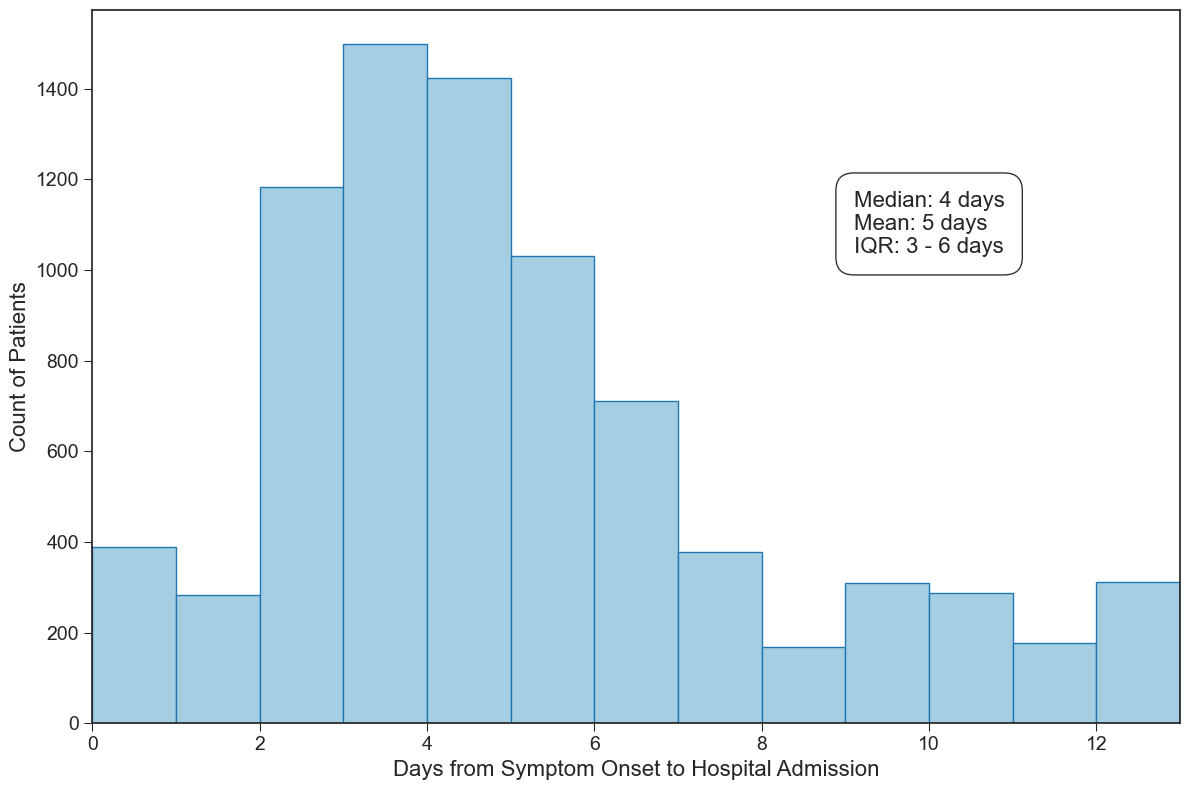

In [50]:
# Filter data for patients who had symptoms on August 1, 2020
filtered_data = OTH_99Q[OTH_99Q['onset_date'] == pd.Timestamp(2020, 8, 1)]

# Calculate descriptive statistics: 25th percentile (Q1), 75th percentile (Q3), median, and mean
q25 = filtered_data['OnsetToHospital'].quantile(0.25)
q75 = filtered_data['OnsetToHospital'].quantile(0.75)
median_value = filtered_data['OnsetToHospital'].median()
mean_value = round(filtered_data['OnsetToHospital'].mean(), 1)

plt.style.use('seaborn-v0_8-ticks')
plt.figure(figsize=(12, 8))

# Plot histogram of 'OnsetToHospital' days for filtered data
plt.hist(filtered_data['OnsetToHospital'],
         bins=13, 
         color=sns.color_palette('Paired')[0], 
         edgecolor=sns.color_palette('Paired')[1]) 

# Create text string for descriptive statistics box
textstr = (
    f"Median: {median_value:.0f} days\n"
    f"Mean: {mean_value:.0f} days\n"
    f"IQR: {q25:.0f} - {q75:.0f} days"
)

# Add a text box on the plot with the descriptive statistics
plt.gca().text(
    0.7, 0.7, textstr, transform=plt.gca().transAxes,
    fontsize=16, verticalalignment='center', horizontalalignment='left',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.8')  # Customize the box style and padding
)

# Set the plot title and axis labels
#plt.title('Distribution of days from symptom onset to hospitalization for patients with symptoms on Aug 1, 2020', fontsize=16)
plt.xlim(0, 13)
plt.xlabel('Days from Symptom Onset to Hospital Admission', fontsize=16)
plt.ylabel('Count of Patients', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()


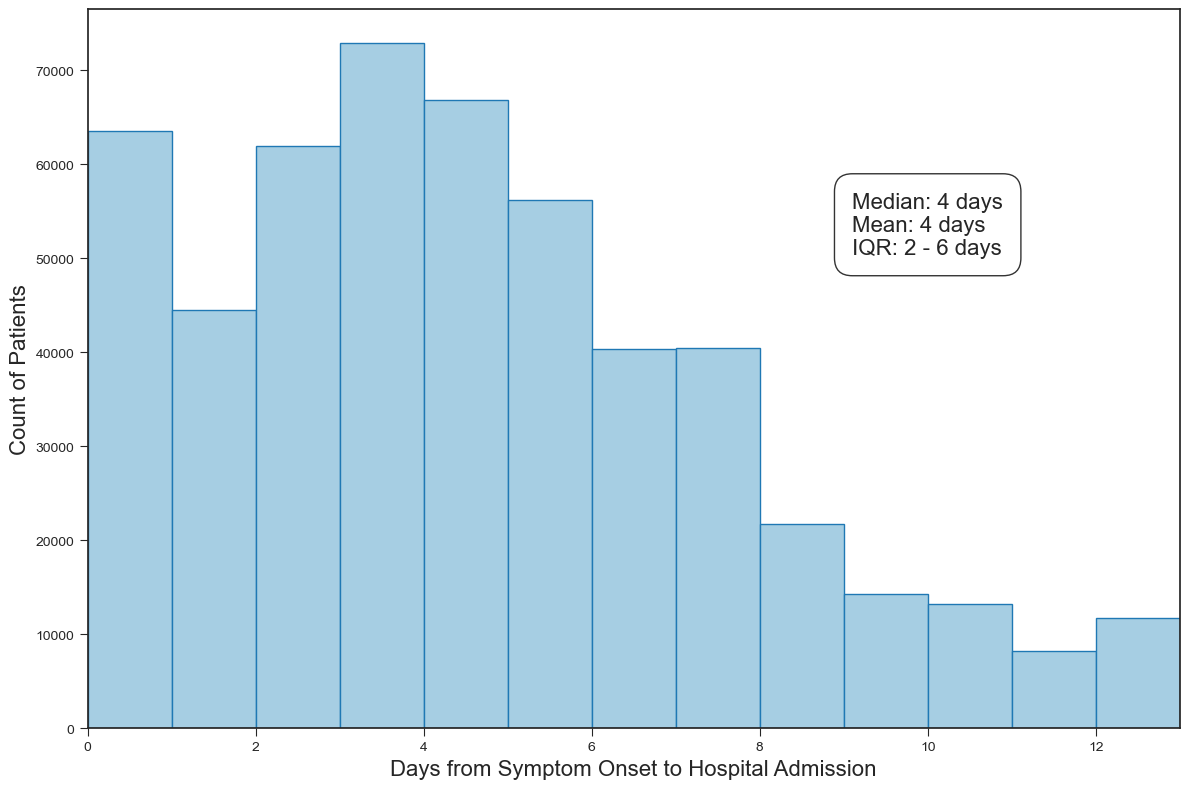

In [70]:
# Filter data for patients who had symptoms up to August 1, 2020
filtered_data = OTH_99Q[OTH_99Q['onset_date'] <= pd.Timestamp(2020, 8, 1)]

# Calculate descriptive statistics: 25th percentile (Q1), 75th percentile (Q3), median, and mean
q25 = filtered_data['OnsetToHospital'].quantile(0.25)
q75 = filtered_data['OnsetToHospital'].quantile(0.75)
median_value = filtered_data['OnsetToHospital'].median()
mean_value = round(filtered_data['OnsetToHospital'].mean(), 1)

plt.style.use('seaborn-v0_8-ticks')
plt.figure(figsize=(12, 8))

# Plot histogram of 'OnsetToHospital' days for filtered data
plt.hist(filtered_data['OnsetToHospital'],
         bins=13, 
         color=sns.color_palette('Paired')[0], 
         edgecolor=sns.color_palette('Paired')[1]) 

# Create text string for descriptive statistics box
textstr = (
    f"Median: {median_value:.0f} days\n"
    f"Mean: {mean_value:.0f} days\n"
    f"IQR: {q25:.0f} - {q75:.0f} days"
)

# Add a text box on the plot with the descriptive statistics
plt.gca().text(
    0.7, 0.7, textstr, transform=plt.gca().transAxes,
    fontsize=16, verticalalignment='center', horizontalalignment='left',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.8')  # Customize the box style and padding
)

# Set the plot title and axis labels
plt.xlim(0, 13)
plt.xlabel('Days from Symptom Onset to Hospital Admission', fontsize=16)
plt.ylabel('Count of Patients', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

In [53]:
onset_to_death_df = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/onset_to_death_df.feather')
onset_to_death_df['HospitalToDeath'] = (onset_to_death_df['death_date']-onset_to_death_df['hospital_date']).dt.days
onset_to_death_df

,onset_date,hospital_date,death_date,state,gender,age,OnsetToDeath,HospitalToDeath
0,2020-07-17,2020-07-20,2020-07-21,23,1,66,4.0,1
1,2020-12-12,2020-12-14,2020-12-17,15,2,58,5.0,3
2,2020-12-15,2020-12-15,2020-12-15,32,1,30,0.0,0
3,2020-06-22,2020-06-28,2020-06-28,28,2,53,6.0,0
4,2020-03-16,2020-03-16,2020-03-28,5,2,47,12.0,12
...,...,...,...,...,...,...,...,...
334777,2023-12-16,2023-12-17,2023-12-31,20,2,64,15.0,14
334778,2023-12-30,2024-01-10,2024-01-29,11,2,77,30.0,19
334779,2023-12-22,2023-12-27,2023-12-28,11,2,41,6.0,1
334780,2023-02-07,2023-02-07,2023-02-13,15,1,41,6.0,6


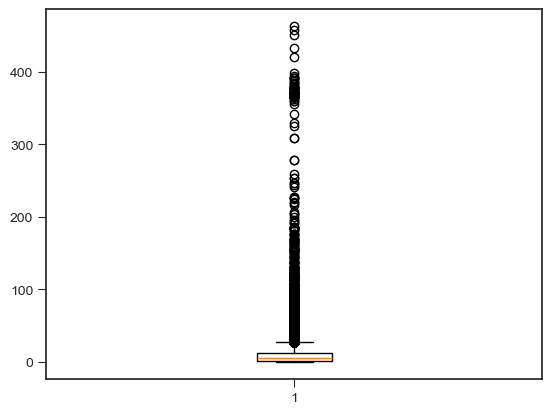

39.0


In [54]:
plt.boxplot(onset_to_death_df['HospitalToDeath'])
plt.show()
print(onset_to_death_df['HospitalToDeath'].quantile(0.99))

In [55]:
# Filter out data beyond the 99th quantile
OTD_99Q = onset_to_death_df[onset_to_death_df['HospitalToDeath'] <= onset_to_death_df['HospitalToDeath'].quantile(0.99)].copy().reset_index(drop=True)
OTD_99Q

,onset_date,hospital_date,death_date,state,gender,age,OnsetToDeath,HospitalToDeath
0,2020-07-17,2020-07-20,2020-07-21,23,1,66,4.0,1
1,2020-12-12,2020-12-14,2020-12-17,15,2,58,5.0,3
2,2020-12-15,2020-12-15,2020-12-15,32,1,30,0.0,0
3,2020-06-22,2020-06-28,2020-06-28,28,2,53,6.0,0
4,2020-03-16,2020-03-16,2020-03-28,5,2,47,12.0,12
...,...,...,...,...,...,...,...,...
331463,2023-12-16,2023-12-17,2023-12-31,20,2,64,15.0,14
331464,2023-12-30,2024-01-10,2024-01-29,11,2,77,30.0,19
331465,2023-12-22,2023-12-27,2023-12-28,11,2,41,6.0,1
331466,2023-02-07,2023-02-07,2023-02-13,15,1,41,6.0,6


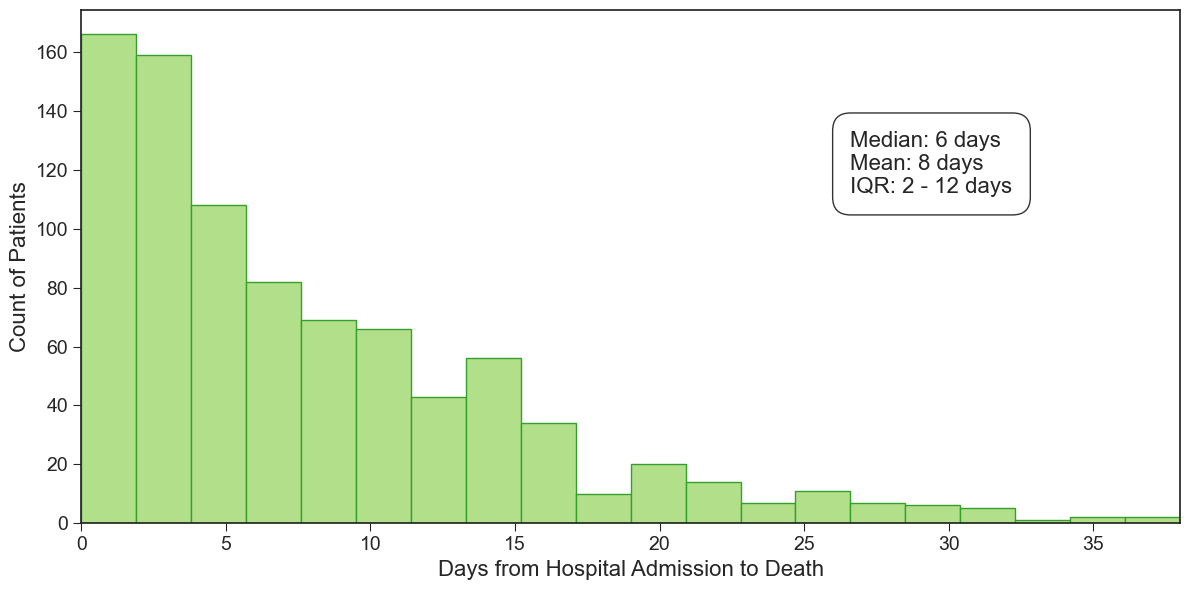

In [60]:
# Filter data for patients who had symptoms on August 1, 2020
filtered_data = OTD_99Q[OTD_99Q['onset_date'] == pd.Timestamp(2020, 8, 1)]

# Calculate descriptive statistics: 25th percentile (Q1), 75th percentile (Q3), median, and mean
q25 = filtered_data['HospitalToDeath'].quantile(0.25)
q75 = filtered_data['HospitalToDeath'].quantile(0.75)
median_value = filtered_data['HospitalToDeath'].median()
mean_value = round(filtered_data['HospitalToDeath'].mean(), 1)

plt.style.use('seaborn-v0_8-ticks')
plt.figure(figsize=(12, 6))

# Plot histogram of 'OnsetToHospital' days for filtered data
plt.hist(filtered_data['HospitalToDeath'],
         bins=20, 
         color=sns.color_palette('Paired')[2], 
         edgecolor=sns.color_palette('Paired')[3]) 

# Create text string for descriptive statistics box
textstr = (
    f"Median: {median_value:.0f} days\n"
    f"Mean: {mean_value:.0f} days\n"
    f"IQR: {q25:.0f} - {q75:.0f} days"
)

# Add a text box on the plot with the descriptive statistics
plt.gca().text(
    0.7, 0.7, textstr, transform=plt.gca().transAxes,
    fontsize=16, verticalalignment='center', horizontalalignment='left',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.8')  # Customize the box style and padding
)

# Set the plot title and axis labels
#plt.title('Distribution of days from hospitalization to death for patients with symptoms on Aug 1, 2020', fontsize=16)
plt.xlim(0, filtered_data['HospitalToDeath'].max())
plt.xlabel('Days from Hospital Admission to Death', fontsize=16)
plt.ylabel('Count of Patients', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

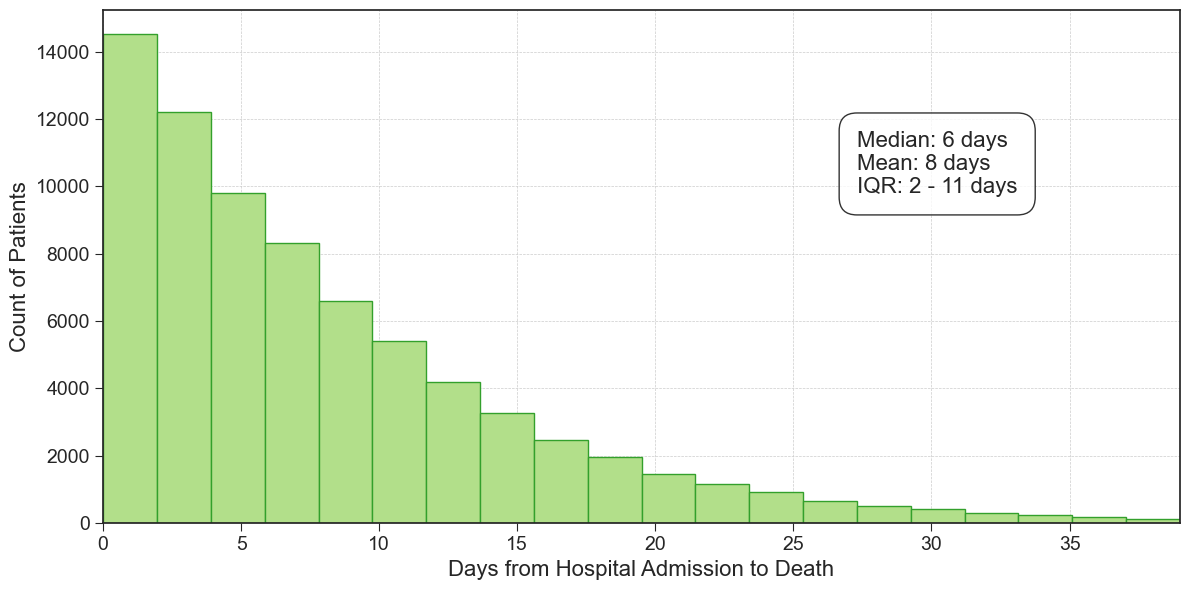

In [63]:
# Filter data for patients who had symptoms up to August 1, 2020
filtered_data = OTD_99Q[OTD_99Q['onset_date'] <= pd.Timestamp(2020, 8, 1)]

# Calculate descriptive statistics: 25th percentile (Q1), 75th percentile (Q3), median, and mean
q25 = filtered_data['HospitalToDeath'].quantile(0.25)
q75 = filtered_data['HospitalToDeath'].quantile(0.75)
median_value = filtered_data['HospitalToDeath'].median()
mean_value = round(filtered_data['HospitalToDeath'].mean(), 1)

plt.style.use('seaborn-v0_8-ticks')
plt.figure(figsize=(12, 6))

# Plot histogram of 'OnsetToHospital' days for filtered data
plt.hist(filtered_data['HospitalToDeath'],
         bins=20, 
         color=sns.color_palette('Paired')[2], 
         edgecolor=sns.color_palette('Paired')[3]) 

# Create text string for descriptive statistics box
textstr = (
    f"Median: {median_value:.0f} days\n"
    f"Mean: {mean_value:.0f} days\n"
    f"IQR: {q25:.0f} - {q75:.0f} days"
)

# Add a text box on the plot with the descriptive statistics
plt.gca().text(
    0.7, 0.7, textstr, transform=plt.gca().transAxes,
    fontsize=16, verticalalignment='center', horizontalalignment='left',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.8')  # Customize the box style and padding
)

# Set the plot title and axis labels
plt.xlim(0, filtered_data['HospitalToDeath'].max())
plt.xlabel('Days from Hospital Admission to Death', fontsize=16)
plt.ylabel('Count of Patients', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()

**Conclusion:** Although the average time bewteen symptom onset and hospitalization (5 days) is shorter than the average time between hospitalization and death (8 days), the longer delay in COVID-19 case reporting compared to death reporting indicates an even higher inneficiency in reporting cases. While this can be attributed to the unprecedented scale and nature of the case counts during the pandemic, it is also understandable that death reporting is more efficient due to the pre-established best practices and regulated processes.

## Data Visualization

In this section we will utilize the `covid_data_df` dataset previously obtained in our ETL notebook.


In [64]:
covid_df = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/covid_df.feather')
covid_df.describe()

,date,state,confirmed_cases,confirmed_deaths
count,45184,45184.000000,45184.000000,45184.000000
mean,2022-01-24 12:00:00,16.500000,170.693498,7.409127
min,2020-02-19 00:00:00,1.000000,0.000000,0.000000
25%,2021-02-05 18:00:00,8.750000,12.000000,0.000000
50%,2022-01-24 12:00:00,16.500000,47.000000,1.000000
75%,2023-01-12 06:00:00,24.250000,146.000000,7.000000
max,2023-12-31 00:00:00,32.000000,19763.000000,270.000000
std,NaN,9.233195,505.363135,17.589680


In [65]:
# Aggregate data at national level
national_df = covid_df.groupby('date').agg(
    {'confirmed_cases': 'sum',
     'confirmed_deaths': 'sum'
    }).reset_index()

national_df

,date,confirmed_cases,confirmed_deaths
0,2020-02-19,1.0,0.0
1,2020-02-20,0.0,0.0
2,2020-02-21,0.0,0.0
3,2020-02-22,2.0,0.0
4,2020-02-23,1.0,0.0
...,...,...,...
1407,2023-12-27,16.0,1.0
1408,2023-12-28,13.0,2.0
1409,2023-12-29,12.0,0.0
1410,2023-12-30,16.0,0.0


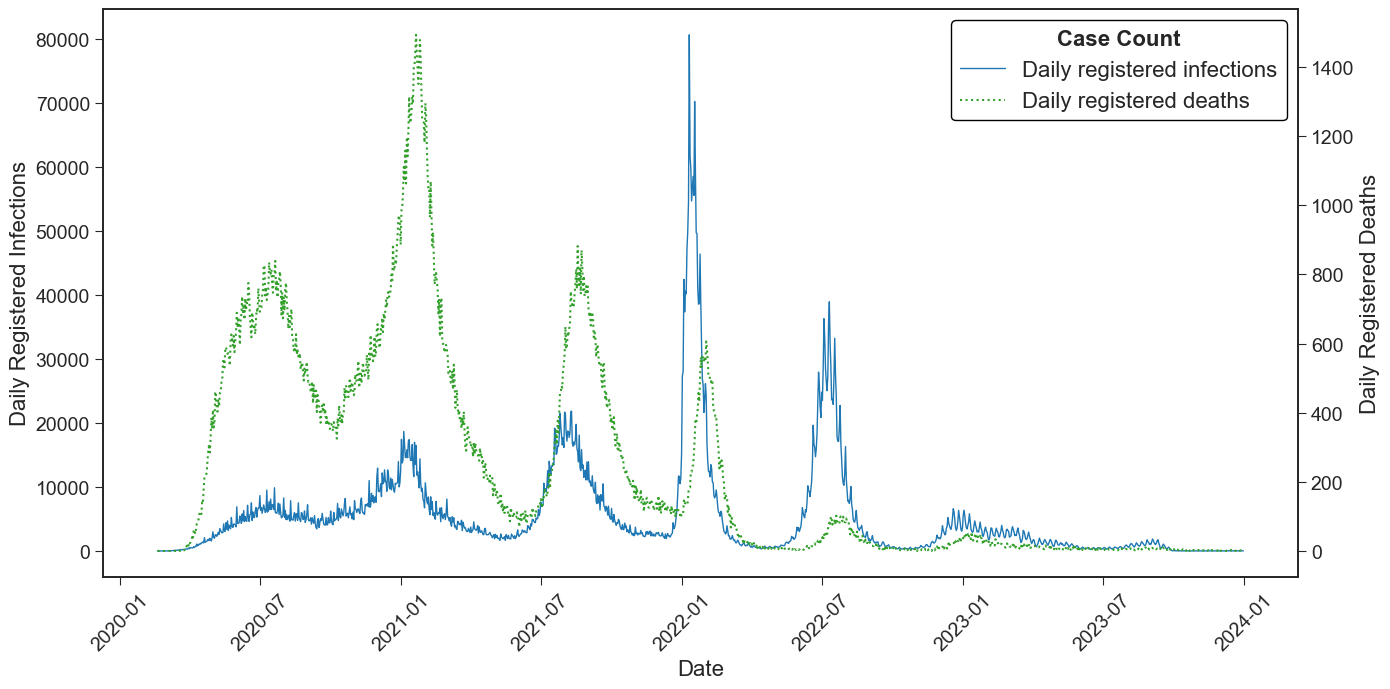

In [248]:
# Create time series plot
plt.style.use('seaborn-v0_8-ticks')
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(national_df['date'], national_df['confirmed_cases'], linewidth=1, linestyle='solid', color=sns.color_palette('Paired')[1], label='Daily registered infections')
ax1.set_ylabel('Daily Registered Infections', fontsize=16)
ax1.set_xlabel('Date', fontsize=16)
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(national_df['date'], national_df['confirmed_deaths'], linewidth=1.5, linestyle='dotted', color=sns.color_palette('Paired')[3], label='Daily registered deaths')
ax2.set_ylabel('Daily Registered Deaths', fontsize=16)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2, labels_1 + labels_2, 
    title='Case Count', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    loc='upper right',
    fontsize=16,
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white'
    )
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

In [84]:
# Create weekly agreggates to reduce variability in data
weekly_covid_df = covid_df.groupby([pd.Grouper(key='date', freq='W-SUN'), 'state']).agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
weekly_covid_df.describe()

,date,state,confirmed_cases,confirmed_deaths
count,6464,6464.000000,6464.000000,6464.000000
mean,2022-01-26 12:00:00,16.500000,1193.164449,51.790532
min,2020-02-23 00:00:00,1.000000,0.000000,0.000000
25%,2021-02-07 00:00:00,8.750000,88.000000,1.000000
50%,2022-01-26 12:00:00,16.500000,331.500000,8.000000
75%,2023-01-15 00:00:00,24.250000,1024.250000,53.000000
max,2023-12-31 00:00:00,32.000000,98152.000000,1702.000000
std,NaN,9.233807,3460.921369,121.480893


In [85]:
weekly_national_df = weekly_covid_df.groupby('date').agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
weekly_national_df

,date,confirmed_cases,confirmed_deaths
0,2020-02-23,4.0,0.0
1,2020-03-01,23.0,0.0
2,2020-03-08,131.0,0.0
3,2020-03-15,624.0,0.0
4,2020-03-22,1152.0,6.0
...,...,...,...
197,2023-12-03,114.0,11.0
198,2023-12-10,106.0,2.0
199,2023-12-17,130.0,13.0
200,2023-12-24,112.0,11.0


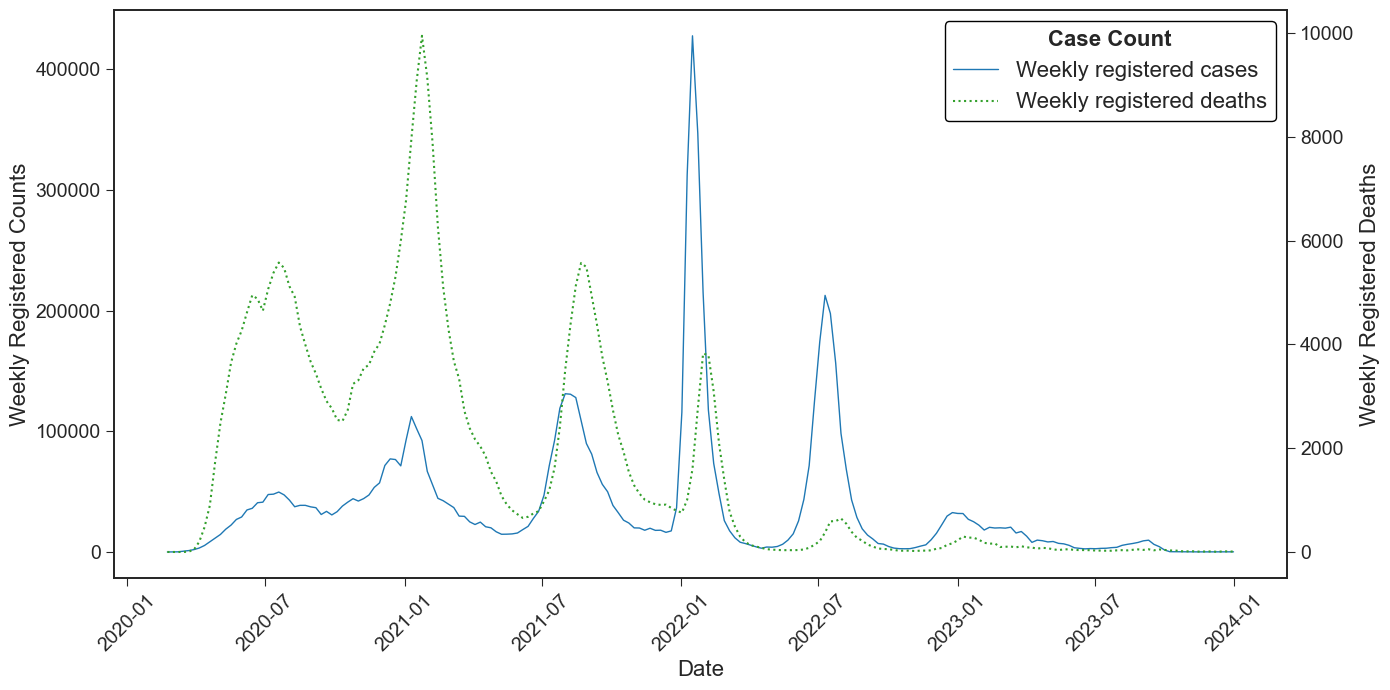

In [250]:
# Plot weekly data time series
plt.style.use('seaborn-v0_8-ticks')
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(weekly_national_df['date'], weekly_national_df['confirmed_cases'], linewidth=1, linestyle='solid', color=sns.color_palette('Paired')[1], label='Weekly registered cases')
ax1.set_ylabel('Weekly Registered Counts', fontsize=16)
ax1.set_xlabel('Date', fontsize=16)
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(weekly_national_df['date'], weekly_national_df['confirmed_deaths'], linewidth=1.5, linestyle='dotted', color=sns.color_palette('Paired')[3], label='Weekly registered deaths')
ax2.set_ylabel('Weekly Registered Deaths', fontsize=16)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2, labels_1 + labels_2, 
    title='Case Count', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    loc='upper right',
    fontsize=16,
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white'
    )
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

In [95]:
weekly_national_df.describe()

,date,confirmed_cases,confirmed_deaths
count,202,202.000000,202.000000
mean,2022-01-26 12:00:00,38181.262376,1657.297030
min,2020-02-23 00:00:00,4.000000,0.000000
25%,2021-02-08 18:00:00,6430.750000,48.500000
50%,2022-01-26 12:00:00,20246.000000,592.500000
75%,2023-01-13 06:00:00,43114.250000,3077.750000
max,2023-12-31 00:00:00,427810.000000,9945.000000
std,NaN,56388.226324,2144.771795


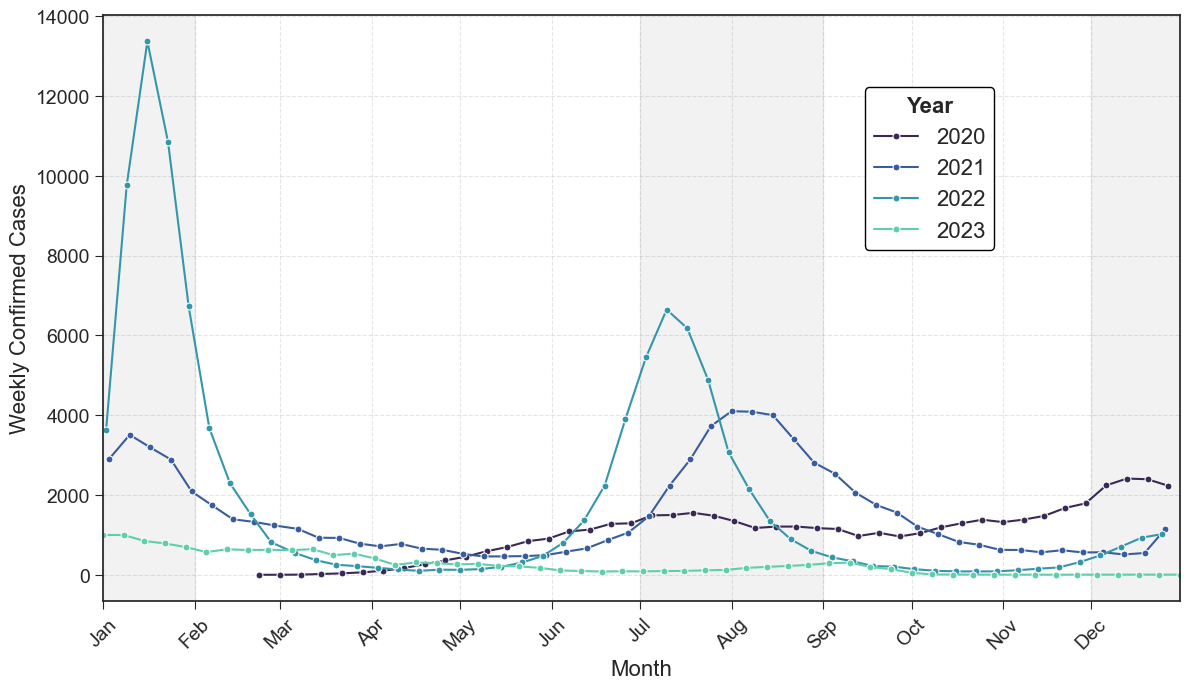

In [98]:
# Duplicate weekly national DF and add dummy column for charting
weekly_data_copy = weekly_covid_df.copy()
weekly_data_copy['day_month'] = weekly_data_copy['date'].dt.strftime('%m-%d')
weekly_data_copy['year'] = weekly_data_copy['date'].dt.year
weekly_data_copy['day_month_date'] = pd.to_datetime('2020-' + weekly_data_copy['day_month'], format='%Y-%m-%d')


plt.figure(figsize=(12, 7))
sns.lineplot(data=weekly_data_copy, 
             x='day_month_date', 
             y='confirmed_cases', 
             hue='year', 
             palette=sns.color_palette('mako',4), 
             marker='o', 
             markersize=5,
             errorbar=None)

# Customize plot
plt.xlabel('Month', fontsize=16)
plt.ylabel('Weekly Confirmed Cases', fontsize=16)
plt.legend(
    bbox_to_anchor=(0.838, 0.895), 
    title='Year', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    loc='upper right',
    fontsize=16,
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white'
    )
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) 
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-12-31'))

plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45) 

# Shade areas for Dec-Jan and Jul-Aug
plt.axvspan(pd.to_datetime('2020-12-01'), pd.to_datetime('2020-12-31'), color='gray', alpha=0.1)
plt.axvspan(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-02-01'), color='gray', alpha=0.1)
plt.axvspan(pd.to_datetime('2020-07-01'), pd.to_datetime('2020-09-01'), color='gray', alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()


## Analysis of Onset to Event Timeframes

In this section we will utilize the `onset_to_hospital_df` and `onset_to_death_df` dataset previously obtained in our ETL notebook. 

In [99]:
# Import datasets
onset_to_death_df = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/onset_to_death_df.feather')
onset_to_hospital_df = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/onset_to_hospital_df.feather')

In [100]:
# Adjust gender column, add age_group classification and add year column
age_bins = [0, 25, 50, 75, float('inf')]
age_labels = ['0-24', '25-49', '50-74', '75+']

onset_to_death_df['gender'] = onset_to_death_df['gender'].map({1: 'Female', 2: 'Male'})
onset_to_death_df['age_group'] = pd.cut(onset_to_death_df['age'], bins=age_bins, labels=age_labels, right=False)
onset_to_death_df['year'] = onset_to_death_df['onset_date'].dt.year

print(onset_to_death_df.head())

onset_to_hospital_df['gender'] = onset_to_hospital_df['gender'].map({1: 'Female', 2: 'Male'})
onset_to_hospital_df['age_group'] = pd.cut(onset_to_hospital_df['age'], bins=age_bins, labels=age_labels, right=False)
onset_to_hospital_df['year'] = onset_to_hospital_df['onset_date'].dt.year

print(onset_to_hospital_df.head())

  onset_date hospital_date death_date  state  gender  age  OnsetToDeath  \
0 2020-07-17    2020-07-20 2020-07-21     23  Female   66           4.0   
1 2020-12-12    2020-12-14 2020-12-17     15    Male   58           5.0   
2 2020-12-15    2020-12-15 2020-12-15     32  Female   30           0.0   
3 2020-06-22    2020-06-28 2020-06-28     28    Male   53           6.0   
4 2020-03-16    2020-03-16 2020-03-28      5    Male   47          12.0   

  age_group  year  
0     50-74  2020  
1     50-74  2020  
2     25-49  2020  
3     50-74  2020  
4     25-49  2020  
  onset_date hospital_date  state  gender  age  OnsetToHospital age_group  \
0 2020-11-30    2020-12-06     24  Female   55                6     50-74   
1 2020-07-20    2020-07-28      8    Male   35                8     25-49   
2 2020-06-10    2020-06-12     31  Female   56                2     50-74   
3 2020-05-30    2020-06-02      1  Female   58                3     50-74   
4 2020-06-30    2020-07-01     31    Male   

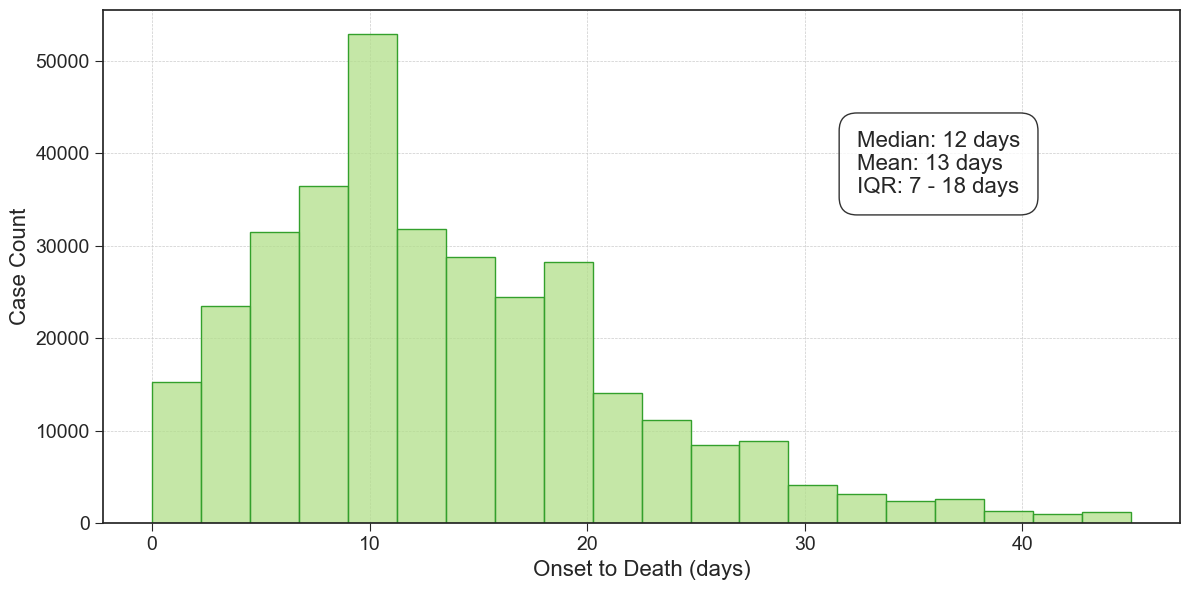

In [104]:
# Create filter to remove outlier values
death_filter = onset_to_death_df['OnsetToDeath'] <= onset_to_death_df['OnsetToDeath'].quantile(0.99)

# Calculate descriptive statistics: 25th percentile (Q1), 75th percentile (Q3), median, and mean
q25 = onset_to_death_df[death_filter]['OnsetToDeath'].quantile(0.25)
q75 = onset_to_death_df[death_filter]['OnsetToDeath'].quantile(0.75)
median_value = onset_to_death_df[death_filter]['OnsetToDeath'].median()
mean_value = round(onset_to_death_df[death_filter]['OnsetToDeath'].mean(), 1)

plt.figure(figsize=(12, 6))
sns.histplot(
    data=onset_to_death_df[death_filter], 
    x='OnsetToDeath', 
    bins=20, 
    kde=False, 
    color=sns.color_palette('Paired')[2],
    edgecolor=sns.color_palette('Paired')[3]
)

# Create text string for descriptive statistics box
textstr = (
    f"Median: {median_value:.0f} days\n"
    f"Mean: {mean_value:.0f} days\n"
    f"IQR: {q25:.0f} - {q75:.0f} days"
)

# Add a text box on the plot with the descriptive statistics
plt.gca().text(
    0.7, 0.7, textstr, transform=plt.gca().transAxes,
    fontsize=16, verticalalignment='center', horizontalalignment='left',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.8')  # Customize the box style and padding
)

# Set the plot title and axis labels
#plt.title('Symptom onset to death distribution for COVID-19 in Mexico (2020-2023)', fontsize=16)
plt.xlabel('Onset to Death (days)', fontsize=16)
plt.ylabel('Case Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()

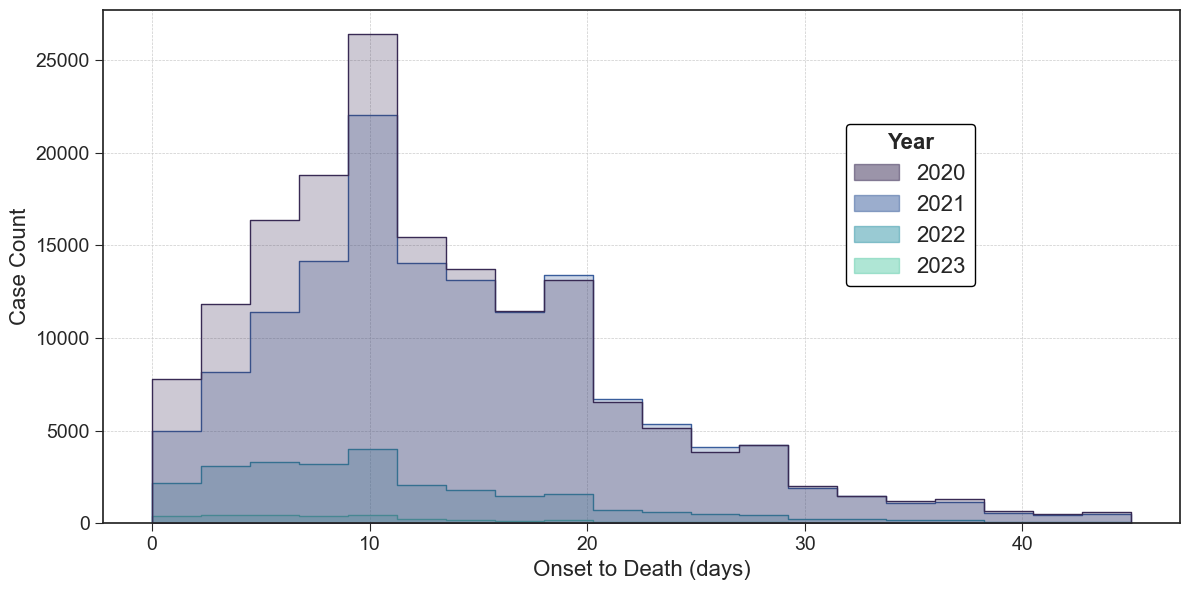

In [106]:
# Create histograms of OnsetToDeath by year
plt.figure(figsize=(12, 6))
sns.histplot(
    data=onset_to_death_df[death_filter], 
    x='OnsetToDeath', 
    hue='year', 
    multiple='layer', 
    bins=20, 
    kde=False, 
    palette=sns.color_palette('mako',4),
    element='step',
    )

# Customize plot
legend_elements = [
    Patch(facecolor=sns.color_palette('mako',4)[0] , edgecolor=sns.color_palette('mako',4)[0], label='2020', alpha=0.5),
    Patch(facecolor=sns.color_palette('mako',4)[1] , edgecolor=sns.color_palette('mako',4)[1], label='2021', alpha=0.5),
    Patch(facecolor=sns.color_palette('mako',4)[2] , edgecolor=sns.color_palette('mako',4)[2], label='2022', alpha=0.5),
    Patch(facecolor=sns.color_palette('mako',4)[3] , edgecolor=sns.color_palette('mako',4)[3], label='2023', alpha=0.5)
]

plt.legend(
    handles=legend_elements,
    fontsize=16, 
    bbox_to_anchor=(0.82, 0.8), 
    title='Year', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white' 
    )

#plt.title('Symptom onset to death distribution by year for COVID-19 patients in Mexico', fontsize=16)
plt.xlabel('Onset to Death (days)', fontsize=16)
plt.ylabel('Case Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

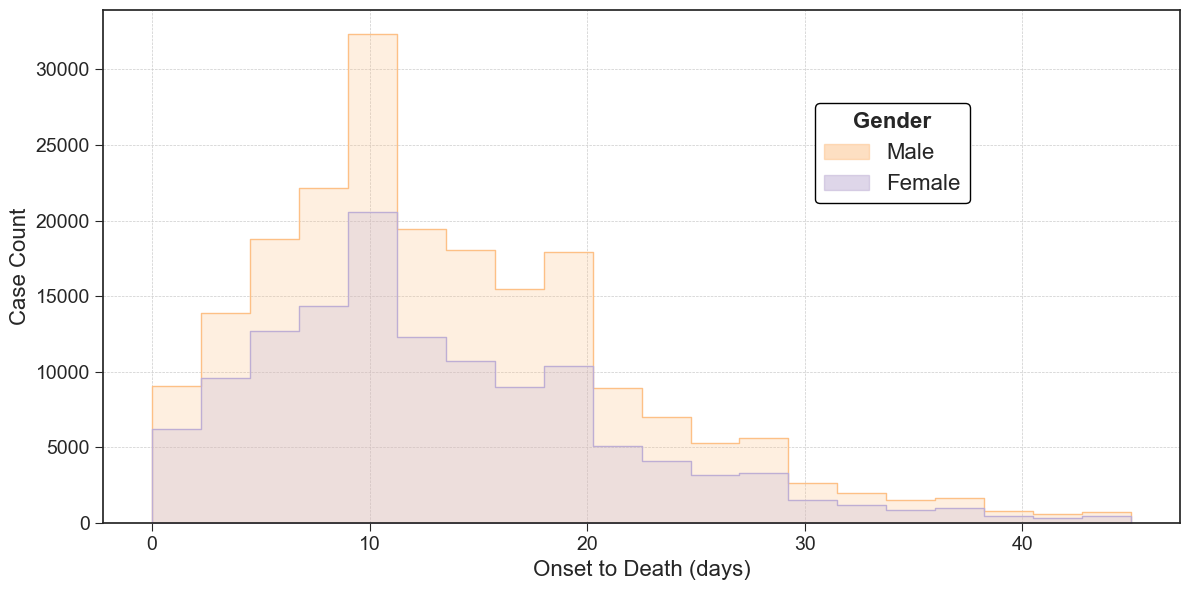

In [262]:
# Create histograms of OnsetToDeath by gender
plt.figure(figsize=(12, 6))
sns.histplot(
    data=onset_to_death_df[death_filter], 
    x='OnsetToDeath', 
    hue='gender', 
    multiple='layer', 
    bins=20, 
    kde=False, 
    palette=sns.color_palette('Accent',3)[1:],
    element='step',
    )

# Customize plot
legend_elements = [
    Patch(facecolor=sns.color_palette('Accent',3)[2] , edgecolor=sns.color_palette('Accent',3)[2], label='Male', alpha=0.5),
    Patch(facecolor=sns.color_palette('Accent',3)[1] , edgecolor=sns.color_palette('Accent',3)[1], label='Female', alpha=0.5),
]

plt.legend(
    handles=legend_elements,
    fontsize=16, 
    bbox_to_anchor=(0.815, 0.84), 
    title='Gender', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white' 
    )


#plt.title('Symptom onset to death distribution by gender for COVID-19 patients in Mexico (2020-2023)', fontsize=16)
plt.xlabel('Onset to Death (days)', fontsize=16)
plt.ylabel('Case Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [110]:
onset_to_death_df.groupby('gender').size().reset_index(name='count')

,gender,count
0,Female,128800
1,Male,205982


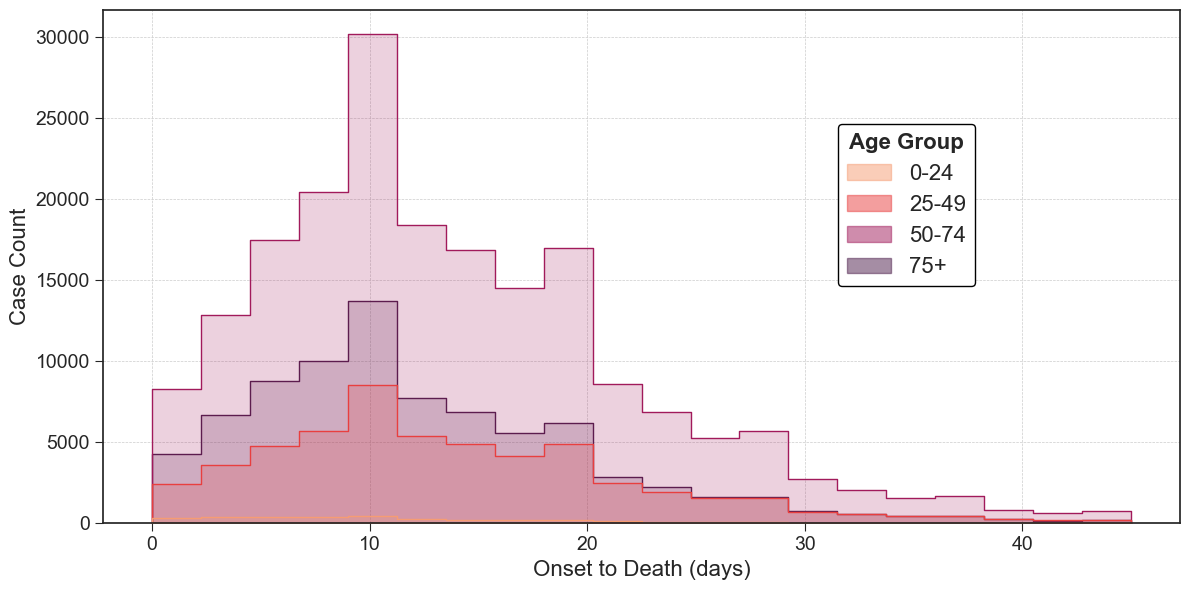

In [263]:
# Create histograms of OnsetToDeath by age_group
plt.figure(figsize=(12, 6))
sns.histplot(
    data=onset_to_death_df[death_filter], 
    x='OnsetToDeath', 
    hue='age_group', 
    multiple='layer', 
    bins=20, 
    kde=False, 
    legend=True,
    element='step',
    palette = sns.color_palette('rocket_r',4),
    alpha=0.2
    )

# Customize the plot
legend_elements = [
    Patch(facecolor=sns.color_palette('rocket_r', 4)[0], edgecolor=sns.color_palette('rocket_r', 4)[0], label='0-24', alpha=0.5),
    Patch(facecolor=sns.color_palette('rocket_r', 4)[1], edgecolor=sns.color_palette('rocket_r', 4)[1], label='25-49', alpha=0.5),
    Patch(facecolor=sns.color_palette('rocket_r', 4)[2], edgecolor=sns.color_palette('rocket_r', 4)[2], label='50-74', alpha=0.5),
    Patch(facecolor=sns.color_palette('rocket_r', 4)[3], edgecolor=sns.color_palette('rocket_r', 4)[3], label='75+', alpha=0.5)
]

plt.legend(
    handles=legend_elements,
    fontsize=16, 
    bbox_to_anchor=(0.82, 0.8), 
    title='Age Group', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white'
)

#plt.title('Symptom onset to death distribution for COVID-19 patients by age group in Mexico (2020-2023)', fontsize=16)
plt.xlabel('Onset to Death (days)', fontsize=16)
plt.ylabel('Case Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [113]:
onset_to_death_df.groupby('age_group', observed=False).size().reset_index(name='count').sort_values(by='count', ascending=False)

,age_group,count
2,50-74,194747
3,75+,81604
1,25-49,55135
0,0-24,3296


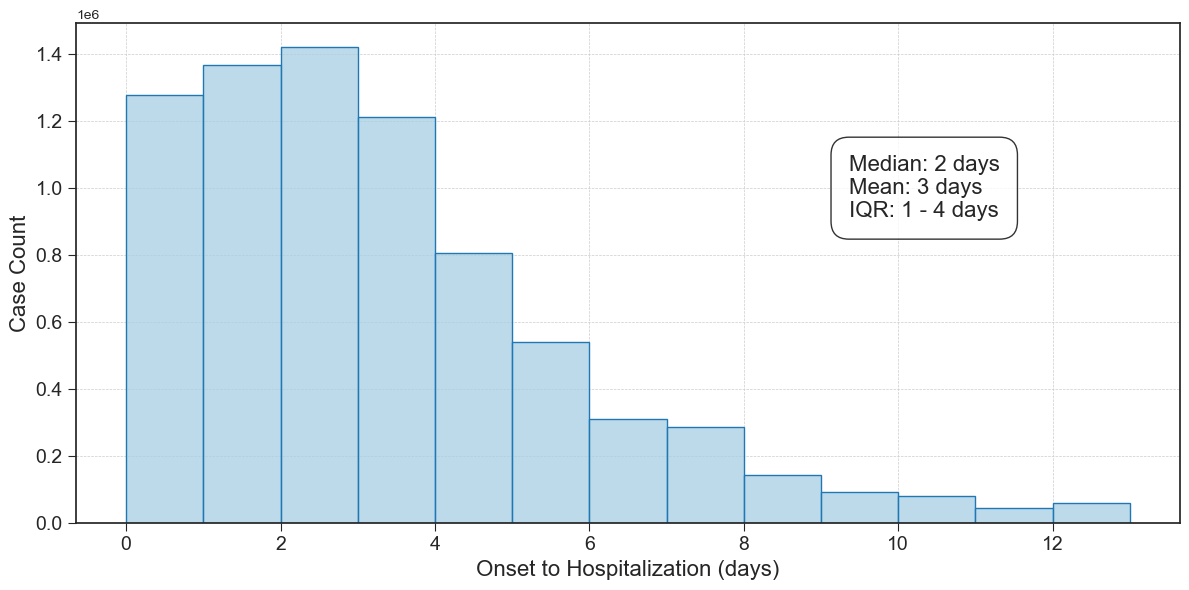

In [264]:
# Create filter to remove outlier values
hosptial_filter = onset_to_hospital_df['OnsetToHospital'] <= onset_to_hospital_df['OnsetToHospital'].quantile(0.99)

# Calculate descriptive statistics: 25th percentile (Q1), 75th percentile (Q3), median, and mean
q25 = onset_to_hospital_df[hosptial_filter]['OnsetToHospital'].quantile(0.25)
q75 = onset_to_hospital_df[hosptial_filter]['OnsetToHospital'].quantile(0.75)
median_value = onset_to_hospital_df[hosptial_filter]['OnsetToHospital'].median()
mean_value = round(onset_to_hospital_df[hosptial_filter]['OnsetToHospital'].mean(), 1)

plt.figure(figsize=(12, 6))
sns.histplot(
    data=onset_to_hospital_df[hosptial_filter], 
    x='OnsetToHospital', 
    bins=13, 
    kde=False, 
    color=sns.color_palette('Paired')[0],
    edgecolor=sns.color_palette('Paired')[1]
)

# Create text string for descriptive statistics box
textstr = (
    f"Median: {median_value:.0f} days\n"
    f"Mean: {mean_value:.0f} days\n"
    f"IQR: {q25:.0f} - {q75:.0f} days"
)

# Add a text box on the plot with the descriptive statistics
plt.gca().text(
    0.7, 0.67, textstr, transform=plt.gca().transAxes,
    fontsize=16, verticalalignment='center', horizontalalignment='left',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.8')  # Customize the box style and padding
)

# Set the plot title and axis labels
#plt.title('Symptom onset to hospitalization distribution for COVID-19 patients in Mexico (2020-2023)', fontsize=16)
plt.xlabel('Onset to Hospitalization (days)', fontsize=16)
plt.ylabel('Case Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()

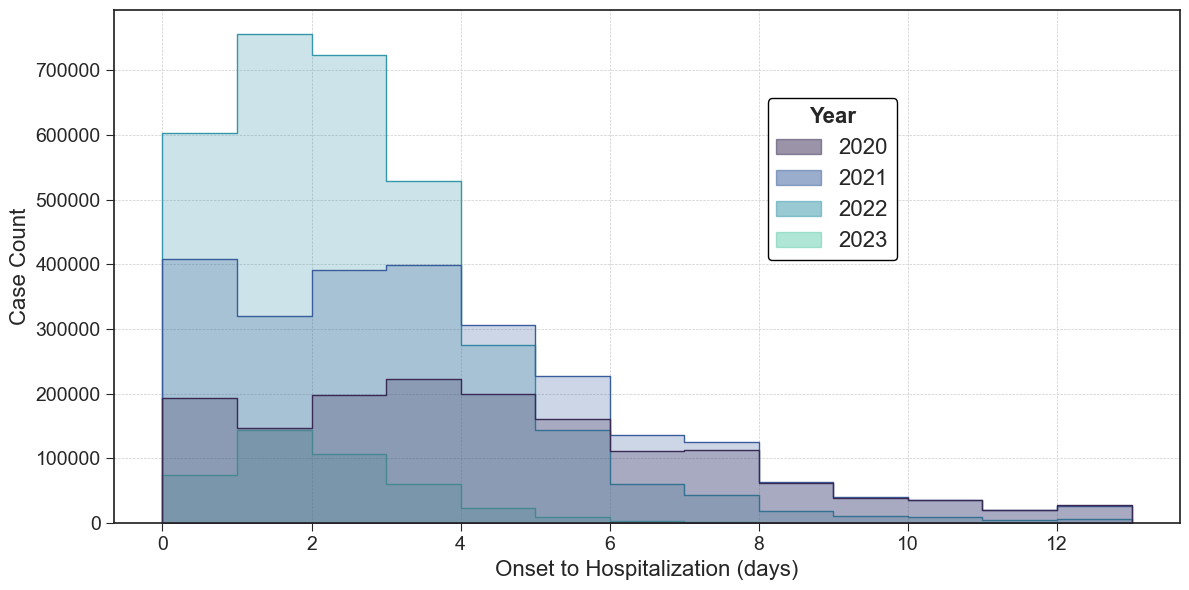

In [265]:
# Create histograms of OnsetToHospital by year
plt.figure(figsize=(12, 6))
sns.histplot(
    data=onset_to_hospital_df[hosptial_filter], 
    x='OnsetToHospital', 
    hue='year', 
    multiple='layer', 
    bins=13, 
    kde=False, 
    palette=sns.color_palette('mako',4),
    element='step',
    )

legend_elements = [
    Patch(facecolor=sns.color_palette('mako',4)[0] , edgecolor=sns.color_palette('mako',4)[0], label='2020', alpha=0.5),
    Patch(facecolor=sns.color_palette('mako',4)[1] , edgecolor=sns.color_palette('mako',4)[1], label='2021', alpha=0.5),
    Patch(facecolor=sns.color_palette('mako',4)[2] , edgecolor=sns.color_palette('mako',4)[2], label='2022', alpha=0.5),
    Patch(facecolor=sns.color_palette('mako',4)[3] , edgecolor=sns.color_palette('mako',4)[3], label='2023', alpha=0.5)
]

plt.legend(
    handles=legend_elements,
    fontsize=16, 
    bbox_to_anchor=(0.745, 0.85), 
    title='Year', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white' 
    )

# Set the plot title and axis labels
plt.xlabel('Onset to Hospitalization (days)', fontsize=16)
plt.ylabel('Case Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()

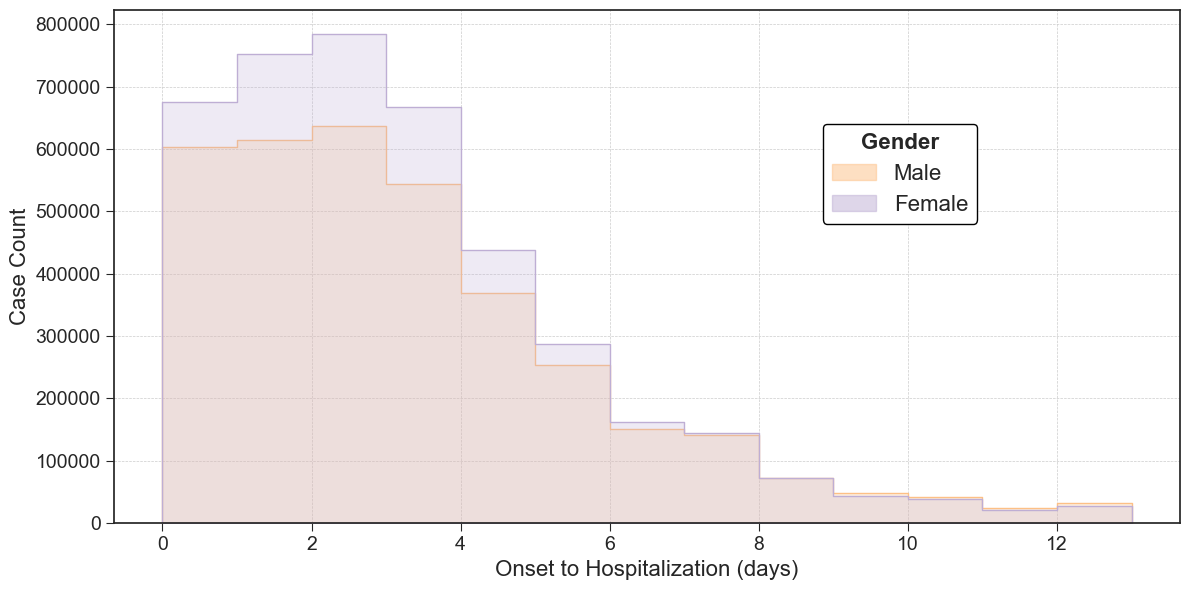

In [266]:
# Create histograms of OnsetToHospital by gender
plt.figure(figsize=(12, 6))
sns.histplot(
    data=onset_to_hospital_df[hosptial_filter], 
    x='OnsetToHospital', 
    hue='gender', 
    multiple='layer', 
    bins=13, 
    kde=False, 
    palette=sns.color_palette('Accent',3)[1:],
    element='step',
    )

# Customize plot
legend_elements = [
    Patch(facecolor=sns.color_palette('Accent',3)[2] , edgecolor=sns.color_palette('Accent',3)[2], label='Male', alpha=0.5),
    Patch(facecolor=sns.color_palette('Accent',3)[1] , edgecolor=sns.color_palette('Accent',3)[1], label='Female', alpha=0.5),
]

plt.legend(
    handles=legend_elements,
    fontsize=16, 
    bbox_to_anchor=(0.82, 0.8), 
    title='Gender', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white' 
    )

#plt.title('Symptom onset to hospitalization distribution by gender for COVID-19 patients in Mexico (2020-2023)', fontsize=16)
plt.xlabel('Onset to Hospitalization (days)', fontsize=16)
plt.ylabel('Case Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()

In [118]:
onset_to_hospital_df.groupby('gender').size().reset_index(name='count')

,gender,count
0,Female,4144612
1,Male,3568003


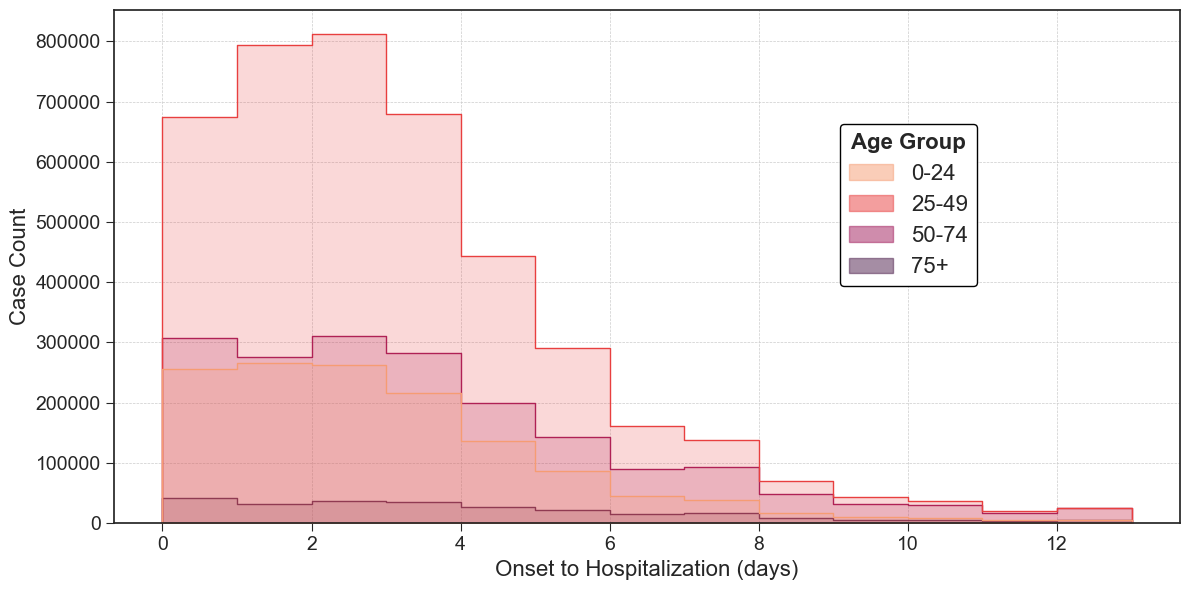

In [267]:
# Create histograms of OnsetToHospital by age_group
plt.figure(figsize=(12, 6))
sns.histplot(
    data=onset_to_hospital_df[hosptial_filter], 
    x='OnsetToHospital', 
    hue='age_group', 
    multiple='layer', 
    bins=13, 
    kde=False, 
    legend=True,
    element='step',
    palette = sns.color_palette('rocket_r',4),
    alpha=0.2
    )

# Customize the plot
legend_elements = [
    Patch(facecolor=sns.color_palette('rocket_r', 4)[0], edgecolor=sns.color_palette('rocket_r', 4)[0], label='0-24', alpha=0.5),
    Patch(facecolor=sns.color_palette('rocket_r', 4)[1], edgecolor=sns.color_palette('rocket_r', 4)[1], label='25-49', alpha=0.5),
    Patch(facecolor=sns.color_palette('rocket_r', 4)[2], edgecolor=sns.color_palette('rocket_r', 4)[2], label='50-74', alpha=0.5),
    Patch(facecolor=sns.color_palette('rocket_r', 4)[3], edgecolor=sns.color_palette('rocket_r', 4)[3], label='75+', alpha=0.5)
]

plt.legend(
    handles=legend_elements,
    fontsize=16, 
    bbox_to_anchor=(0.82, 0.8), 
    title='Age Group', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white'
)

#plt.title('Symptom onset to hospitalization distribution for COVID-19 patients in Mexico by age group', fontsize=16)
plt.xlabel('Onset to Hospitalization (days)', fontsize=16)
plt.ylabel('Case Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [120]:
onset_to_hospital_df.groupby('age_group', observed=False).size().reset_index(name='count').sort_values(by='count', ascending=False)

,age_group,count
1,25-49,4214986
2,50-74,1883249
0,0-24,1356318
3,75+,258062


## Spatial Analysis



In [142]:
#Download the shapefile of mexico's states from INEGI https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=794551067314
mexico_gdf = gpd.read_file('/Users/ro/Downloads/mg_2023_integrado/conjunto_de_datos/00ent.shp')
mexico_gdf['CVE_ENT'] = mexico_gdf['CVE_ENT'].astype(int)
mexico_gdf.head()

,CVEGEO,CVE_ENT,NOMGEO,geometry
0,01,1,Aguascalientes,"POLYGON ((2469550.852 1159302.643, 2469738.209..."
1,02,2,Baja California,"MULTIPOLYGON (((1313480.513 1831458.607, 13135..."
2,03,3,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946..."
3,04,4,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491..."
4,05,5,Coahuila de Zaragoza,"POLYGON ((2469501.165 1978862.429, 2469539.651..."


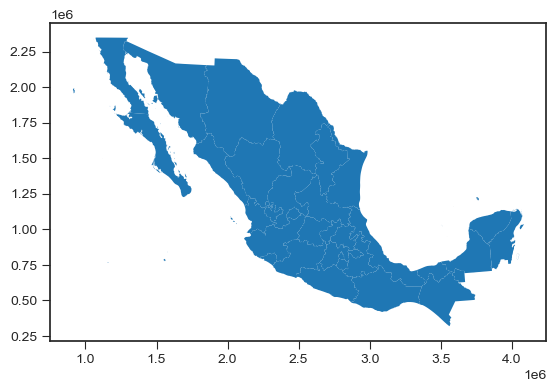

In [122]:
plt.style.use('seaborn-v0_8-ticks')
mexico_gdf.plot()
plt.show()

In [123]:
weekly_state_gdf = pd.merge(
    weekly_covid_df,             
    mexico_gdf[['CVE_ENT','NOMGEO','geometry']],
    left_on='state',   
    right_on='CVE_ENT',    
    how='left'          
)

weekly_state_gdf = weekly_state_gdf.drop('CVE_ENT', axis=1)
weekly_state_gdf.rename(columns={'NOMGEO':'state_name'})

weekly_state_gdf = gpd.GeoDataFrame(weekly_state_gdf, geometry='geometry')
weekly_state_gdf.head()

,date,state,confirmed_cases,confirmed_deaths,NOMGEO,geometry
0,2020-02-23,1,0.0,0.0,Aguascalientes,"POLYGON ((2469550.852 1159302.643, 2469738.209..."
1,2020-02-23,2,0.0,0.0,Baja California,"MULTIPOLYGON (((1313480.513 1831458.607, 13135..."
2,2020-02-23,3,0.0,0.0,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946..."
3,2020-02-23,4,0.0,0.0,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491..."
4,2020-02-23,5,0.0,0.0,Coahuila de Zaragoza,"POLYGON ((2469501.165 1978862.429, 2469539.651..."


In [42]:
infection_peaks = ['2020-07-19','2021-01-17','2021-08-08','2022-01-16','2022-07-10','2023-01-01','2023-09-10']

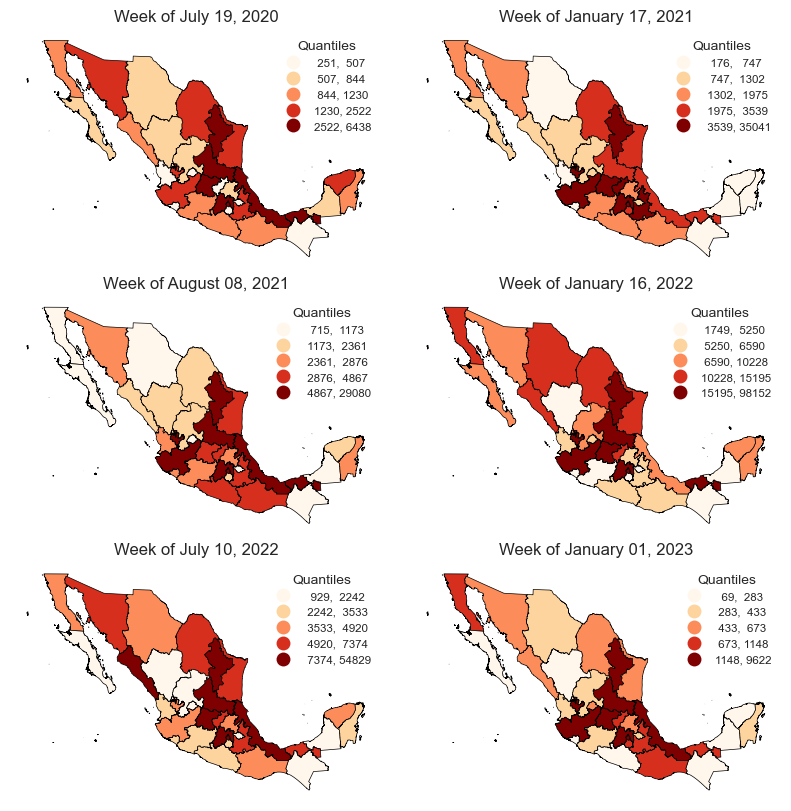

In [253]:
# List of peak infection dates
infection_peaks = ['2020-07-19', '2021-01-17', '2021-08-08', '2022-01-16', '2022-07-10', '2023-01-01']

# Convert to datetime objects
infection_peaks = [pd.Timestamp(date) for date in infection_peaks]

# Determine the grid size based on the number of plots
n_plots = len(infection_peaks)
n_cols = 2  # Number of columns in the grid
n_rows = (n_plots + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create the grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8), constrained_layout=True)
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

# Loop through each peak date and corresponding subplot axis
for idx, (specific_day, ax) in enumerate(zip(infection_peaks, axes)):
    # Filter the data for the specific day
    filtered_date = weekly_state_gdf[weekly_state_gdf['date'] == specific_day]

    # Ensure the filtered data is a GeoDataFrame
    if not isinstance(filtered_date, gpd.GeoDataFrame):
        filtered_date = gpd.GeoDataFrame(filtered_date, geometry='geometry')

    # Create the plot on the current axis
    filtered_date.plot(
        column='confirmed_cases',  
        cmap='OrRd',          
        ax=ax,                   
        edgecolor='black',       
        linewidth=0.5,           
        legend=True, 
        legend_kwds={
            'loc': 'upper right',  
            'fontsize': 'small',
            'title': 'Quantiles',
            'fmt': '{:.0f}' 
        },    
        scheme='quantiles',
        k=5      
    )

    # Add title and remove axis
    ax.set_title(f'Week of {specific_day.strftime("%B %d, %Y")}', fontsize=12)
    ax.set_axis_off()
    
# Hide any empty subplots if n_plots is not a perfect multiple of n_cols
for ax in axes[n_plots:]:
    ax.set_visible(False)

# Display the entire grid of plots
#plt.suptitle('Weekly confirmed COVID-19 cases by state during major infection peaks', fontsize=16)
plt.show()


In [141]:
pop_values = pd.read_excel('/Users/ro/Downloads/INEGI_2020_POPULATION.xlsx')

# Save as a feather file in the Data folder for later use
data_folder = '/Users/ro/Desktop/Undergrad_AM_Thesis/Data'
file_path = os.path.join(data_folder, 'INEGI_2020_State_Population.feather')
pop_values.to_feather(file_path)

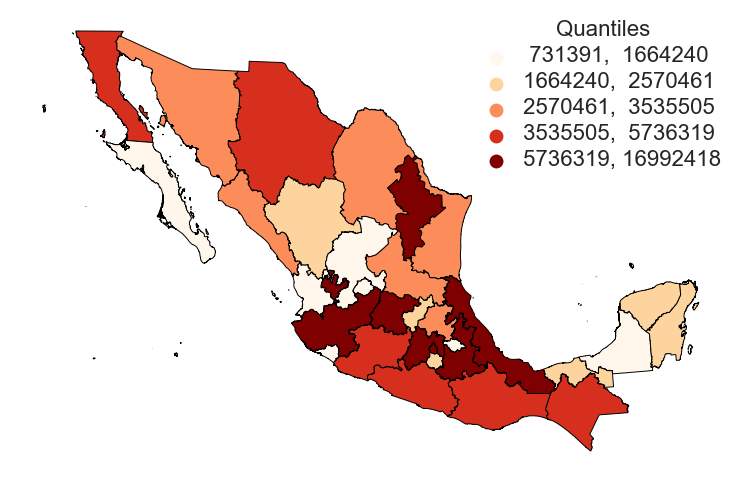

In [254]:
pop_values_gdf = pd.merge(pop_values, mexico_gdf, how='left', left_on='state', right_on='CVE_ENT')
pop_values_gdf = pop_values_gdf.drop(['CVE_ENT', 'CVEGEO', 'NOMGEO'], axis=1)
pop_values_gdf = gpd.GeoDataFrame(pop_values_gdf, geometry='geometry')

ax = pop_values_gdf.plot(
    column='population',  
    cmap='OrRd',                          
    edgecolor='black',       
    linewidth=0.7,           
    legend=True,  
    legend_kwds={
        'loc': 'upper right',  
        'fontsize': 'small',
        'title': 'Quantiles',
        'fmt': '{:.0f}'
    },    
    scheme='quantiles',
    k=5,
    figsize=(12, 6)   
)

# Access the legend object and adjust the font size
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_fontsize(16)  # Set desired font size here

# Adjust the title font size
leg.set_title('Quantiles', prop={'size': 16}) 

ax.set_axis_off()
#plt.title('Population estimates for Mexico by INEGI (2020)', fontsize=16)
plt.show()

## Time Series Analysis

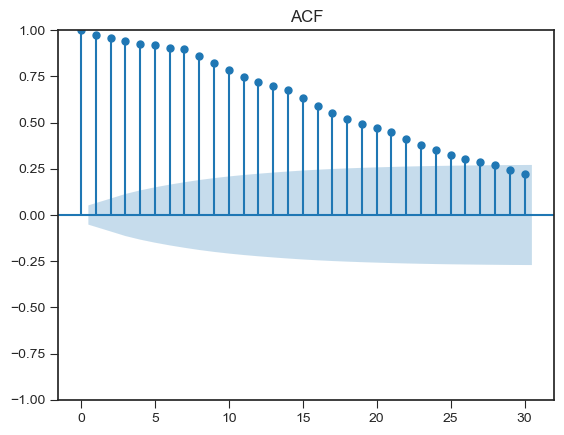

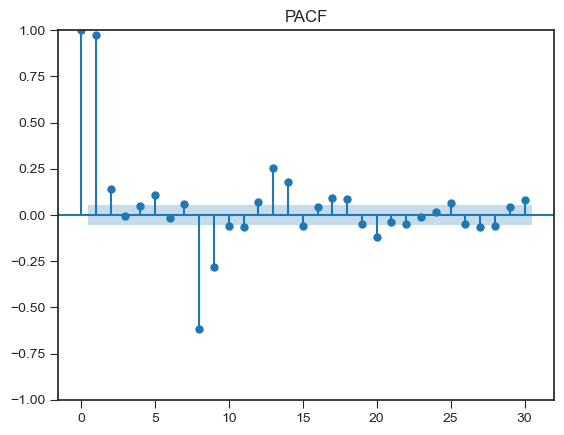

In [271]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(national_df['confirmed_cases'], lags=30, title='ACF')
plot_pacf(national_df['confirmed_cases'], lags=30, title='PACF')
plt.show()

For our daily reports on COVID-19 cases the ACF and PACF plots indicate the time series could follow an AR(2) process with slight seasonal patterns repeating every 7 days. The observed AR structure is within our expectations given the nature of the time series and disease transmission reliance on infected counts of previous dates.

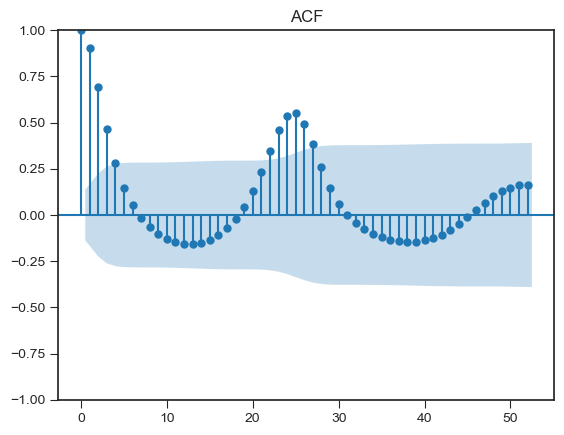

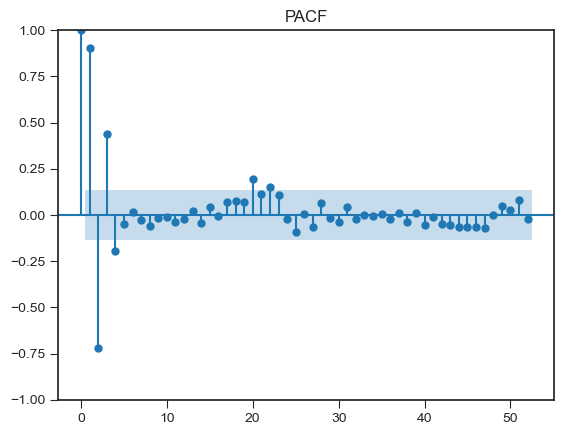

In [273]:
plot_acf(weekly_national_df['confirmed_cases'].values, lags=52, title='ACF')
plot_pacf(weekly_national_df['confirmed_cases'].values, lags=52, title='PACF')
plt.show()

For the weekly aggregates of COVID-19 confirmed cases we also observe an AR structure, only that this time it could be an AR(4), additionally, we can now identify a cyclic pattern of seasonality repeating around every 25 weeks corresponding to the 6-month intervals previously observed in contagion peaks.

## Demographics

In [143]:
#Modifying the 202 INEGI census data https://www.inegi.org.mx/programas/ccpv/2020/
demo_df = pd.read_excel('/Users/ro/Downloads/INEGI_2020_POP_AGE_GENDER.xlsx')

# Save as a feather file in the Data folder for later use
data_folder = '/Users/ro/Desktop/Undergrad_AM_Thesis/Data'
file_path = os.path.join(data_folder, 'INEGI_2020_AGE_GENDER.feather')
demo_df.to_feather(file_path)

In [219]:
demo_df['prop_hombres'] = demo_df['hombres'] / demo_df['poblacion'] *100
demo_df['prop_mujeres'] = demo_df['mujeres'] / demo_df['poblacion'] *100
demo_df.head()

,edad,edad_numero,poblacion,hombres,mujeres,prop_hombres,prop_mujeres,age_group
0,00 años,0,1812977,916140,896837,50.532356,49.467644,0-24
1,01 años,1,1909958,967223,942735,50.641061,49.358939,0-24
2,02 años,2,2041119,1031816,1009303,50.551487,49.448513,0-24
3,03 años,3,2108406,1060809,1047597,50.313317,49.686683,0-24
4,04 años,4,2174905,1101494,1073411,50.645614,49.354386,0-24


In [170]:
# Adjust gender column, add age_group classification and add year column
age_bins = [0, 25, 50, 75, float('inf')]
age_labels = ['0-24', '25-49', '50-74', '75+']

demo_df['age_group'] = pd.cut(demo_df['edad_numero'], bins=age_bins, labels=age_labels, right=False)
demo_df.head()

,edad,edad_numero,poblacion,hombres,mujeres,prop_hombres,prop_mujeres,age_group
0,00 años,0,1812977,916140,896837,0.505324,0.494676,0-24
1,01 años,1,1909958,967223,942735,0.506411,0.493589,0-24
2,02 años,2,2041119,1031816,1009303,0.505515,0.494485,0-24
3,03 años,3,2108406,1060809,1047597,0.503133,0.496867,0-24
4,04 años,4,2174905,1101494,1073411,0.506456,0.493544,0-24


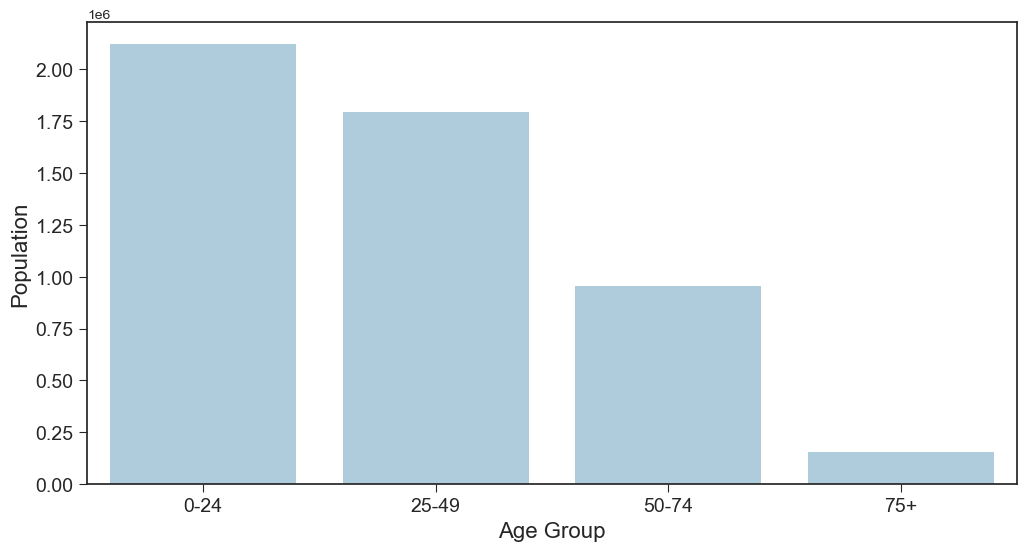

In [178]:
colors = sns.color_palette('Paired')
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')

sns.barplot(data=demo_df, x='age_group', y='poblacion', errorbar=None, color=colors[0])
plt.xlabel('Age Group', fontsize=16)
plt.ylabel('Population', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

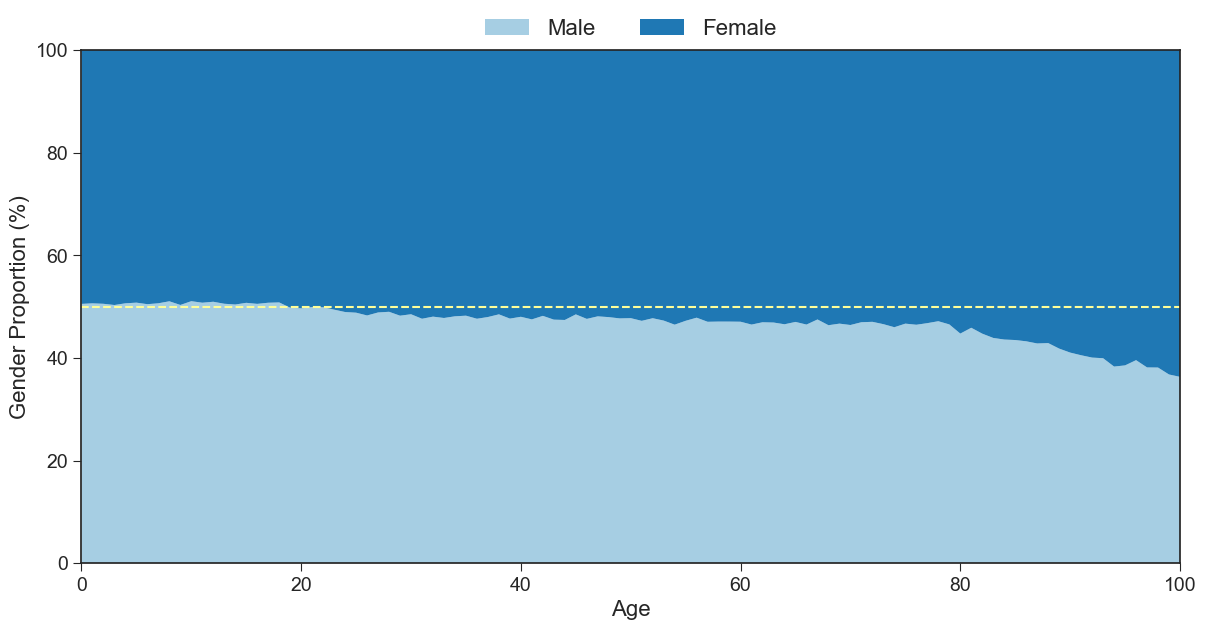

In [244]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.stackplot(demo_df['edad_numero'], demo_df['prop_hombres'], demo_df['prop_mujeres'], colors=[colors[0],colors[1]], labels=['Male','Female'])
plt.axhline(y=50, color=colors[10], linestyle='--')
            
plt.xlabel('Age', fontsize=16)
plt.ylabel('Gender Proportion (%)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=16)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()